# __WSI - ćwiczenie 5.__

### __Sztuczne sieci neuronowe__

#### __Treść ćwiczenia__

- Celem cwiczenia jest implementacja perceptronu wielowarstwowego oraz wybranego algorytmu
optymalizacji gradientowej z algorytmem propagacji wstecznej.
- Nastepnie nalezy wytrenowac perceptron wielowarstwowy do klasyfikacji zbioru danych wine
(https://archive.ics.uci.edu/ml/datasets/wine). Zbiór ten dostepny jest w pakiecie scikitlearn
(sklearn.datasets.load wine).

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, log_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from seaborn import heatmap
import plotly.express as px
from math import log, inf, e, tanh, sqrt, ceil
from sklearn.utils import resample, shuffle
import unittest
from sklearn.datasets import load_wine
from scipy.special import expit, logit, softmax
from IPython.display import Image


RNG = np.random.default_rng()

cele: 
- perceptron wielowarstwowy, implementacja ze zmienną ilością warstw głębokich oraz zmienną ilością długości wektora neuronów
- kilka algorytmów optymalizacji wag sieci (gradient prosty, SGD, algorytm ewolucyjny??)

zadania:
1. model sieci
2. propagacja wsteczna
3. optymalizacja wag

__Weight matrix per layer:__

$$
\theta^{l}=
\left[\begin{array}{ccc}
\omega_{1,1}& \cdots&\omega_{1,k+1}\\
\vdots&\ddots&\vdots\\
\omega_{n,1}&\cdots&\omega_{n,k+1}
\end{array}\right]
$$
where  $ \omega_{i,j} $ is the $j$-th weight of the $i$-th neuron (in layer $l$), and $ \omega_{i,k+1} $ is its bias

__Matrix of layers:__

$$
\Theta=
\left[\begin{array}{ccc}
\theta^{1}& \cdots&\theta^{\lambda}\
\end{array}\right]
$$
where  $ \theta^{\lambda} $ is the output layer 

__Input data vector:__

$$
y^0=\left[\begin{array}{ccc}
x^T& 1
\end{array}\right]^T
$$
it is extended by 1 to allow easier multiplication

__Opertation of a single neuron:__

$$
y^l_i=\psi(\theta^l_i y^{l-1})
$$

$\psi$ is the neuron activation function

__Output layer:__

$$
f_i(x, \Theta)=\theta^\lambda_i y^\lambda
$$

__Backpropagation__
$$
\frac{de}{ds^l_i}=\frac{de}{dy^l_i}\frac{∂\psi^l(s^l_i)}{∂s^l_i}
$$

$$
\frac{de}{dy^l_i}=\sum_{\gamma} \frac{de}{ds^{l+1}_\gamma}\theta^{l+1}_{\gamma,i} 
$$
For the last layer this can be calculated immidiately:

$$
\frac{∂e}{∂\theta^l_{i,j}}=\frac{de}{ds^l_i}y^{l-1}_j= \frac{de}{dy^l_i} \frac{∂\psi^l(s^l_i)}{∂s^l_i}y^{l-1}_j
$$

For the rest:
$$
\frac{∂e}{∂\theta^l_{i,j}}= \left( \sum_{\gamma} \frac{de}{ds^{l+1}_\gamma}\theta^{l+1}_{\gamma,i} \right) \frac{∂\psi^l(s^l_i)}{∂s^l_i}y^{l-1}_j
$$

So in order to calculate all the derivatives we need to first calculate all derivatives of neuron input sums

__Default weigths initialization:__

todo

In [4]:
class MLP():
    """
    todo fully-connected?

    Attribubtes:
        _layers: 

    Methods:
        fit:
    """
    def __init__(self, dimensions:list, feature_number:int, activations:list=None, loss_func:str = None) -> None:
        """
        todo

        Args:
            dimensions: starting from first hidden layer
            activations: last actvation function should be linear if a basic MLP is being modeled

        Returns:
            MLP object

        Raises:
            None
        """

        # todo assertions

        self._layers = np.array([np.empty((dimensions[0], feature_number + 1))] + \
                                [np.empty((dimensions[i+1], dimensions[i]+1)) for i in range(len(dimensions)-1)], 
                                dtype=object)
        
        self._activation_names = activations
        self._loss_func_name = loss_func
        
        self._activation_funcs = {
            'linear': lambda x: x,
            'logistic':lambda x: expit(x),
            'tanh': lambda x: tanh(x),
            'ReLU':lambda x: max(0, x),
            'softmax': lambda x: softmax(x)
        }
        self._activation_derivs = {
            'linear': lambda x: 1,
            'logistic':lambda x: expit(x) * (1 - expit(x)),
            'tanh': lambda x: 1 - tanh(x)**2,
            'ReLU': lambda x: 1*(x>0),
            'softmax': lambda x: softmax(x)*(1-softmax(x))
        }

        self._loss_funcs = {
            'MSE': mean_squared_error,
            'crossEntropy': log_loss
        }

        self._loss_func_derivs = {
            'MSE': lambda v, t: 2*(v - t),
            'crossEntropy': lambda v, t: (v-t)/(v*(1-v))
            }

    def initialize_weights(self, strategy='default'):
        # todo strategies
        if strategy == 'default':
            for layer in self._layers[:-1]:
                size = layer.shape[1]
                size_sqrt = sqrt(size)
                with np.nditer(layer, op_flags=['writeonly']) as it:
                    for w in it:
                        w[...] = RNG.uniform(-1/size_sqrt, 1/size_sqrt)
            self._layers[-1].fill(0)
        if strategy == 'ones':
            for layer in self._layers:
                layer.fill(1)

    def get_activated_vector(self, layer_vector, activation_func_name):
        if activation_func_name == 'softmax':
            return softmax(layer_vector).tolist()
        return [self._activation_funcs[activation_func_name](s) for s in layer_vector]

    def get_derived_vector(self, layer_vector, activation_func_name):
        if activation_func_name == 'softmax':
            return self._activation_derivs[activation_func_name](layer_vector)
        return [self._activation_derivs[activation_func_name](s) for s in layer_vector]

    def feed_forward(self, input_vector):
        # todo description
        # this returns a vector consisting of tuples 
        # of single neuron input sum and effective activated output 
        all_inputs_outputs = []
        current_layer_activated_outputs = input_vector
        for layer, activation_name in zip(self._layers, self._activation_names):
            current_layer_activated_outputs = current_layer_activated_outputs + [1]
            current_layer_input_sums = [np.matmul(weights, current_layer_activated_outputs) for weights in layer]
            current_layer_activated_outputs = self.get_activated_vector(current_layer_input_sums, activation_name)
            current_layer_pairs = np.array([current_layer_input_sums, current_layer_activated_outputs]).T
            all_inputs_outputs.append(current_layer_pairs)
        return all_inputs_outputs

    def propagate(self, input_vector):
        return self.feed_forward(input_vector)[-1][:, 1].tolist()

    def backprop(self, input_vector, true_output_vector):
        
        gradient_estimate = []
        
        all_inputs_outputs = self.feed_forward(input_vector)
        all_partial_deriv_input_sums = [self.get_derived_vector(layer[:, 0], name) for layer, name in zip(all_inputs_outputs, self._activation_names)]
        
        # configure for output layer
        # calculate loss derivative values
        total_deriv_outputs = [self._loss_func_derivs[self._loss_func_name](output, true_value) for output, true_value in zip(all_inputs_outputs[-1][:,1], true_output_vector)]
        # all outputs appended with 1 (bias) at each layer
        all_outputs_with_input_vector = [input_vector + [1]] + [layer[:,1].tolist() + [1] for layer in all_inputs_outputs]
        # for each layer
        layer_idx = -1
        for layer_idx in range(len(self._layers)-1, -1, -1):
            partial_deriv_input_sums = all_partial_deriv_input_sums[layer_idx]
            total_deriv_input_sums = np.multiply(total_deriv_outputs, partial_deriv_input_sums)
            # calculate estimated gradient for layer 
            layer_gradient = np.matmul(total_deriv_input_sums[np.newaxis].T, np.array(all_outputs_with_input_vector[layer_idx])[np.newaxis])
            gradient_estimate.insert(0, layer_gradient)
            
            # prepare for next layer 
            if not layer_idx == 0:
                # shorten the arrays by 1 to avoid calculating derivatives for biases
                total_deriv_outputs = [np.multiply(total_deriv_input_sums, neuron_weights).sum() for neuron_weights in self._layers[layer_idx][:,:-1].T]

        return np.array(gradient_estimate, dtype=object)

    def BGD_step(self, data, target_labels, learning_rate):
        gradient_sum = np.shape(self._layers)
        for _, row in data.iterrows():
            gradient_sum = gradient_sum + self.backprop(row.drop(target_labels).tolist(), 
                                                         row[target_labels].tolist())
        avg_gradient = gradient_sum / data.shape[0]
        self._layers = self._layers - (avg_gradient * learning_rate)
    
    def SGD_step(self, data, target_labels, learning_rate, mini_batch_size):
        for i in range(ceil(data.shape[0]/mini_batch_size)):
            batch = data.iloc[i*mini_batch_size:(i+1)*mini_batch_size]
            self.BGD_step(batch, target_labels, learning_rate)

    def train(self, train_data, target_labels, learning_rate, strategy='BGD', epoch_number=100, mini_batch_size=10, monitor=False, test_data=None):
        # shuffle rows
        train_data.sample(frac = 1)
        errors = []
        for i in range(epoch_number):
            if strategy == 'BGD':
                self.BGD_step(train_data, target_labels, learning_rate)
            if strategy == 'SGD':
                self.SGD_step(train_data, target_labels, learning_rate, mini_batch_size)
            if monitor:
                pred = self.predict(test_data.drop(target_labels, axis=1)).apply(lambda row: row[0])
                current_error = self._loss_funcs[self._loss_func_name](test_data[target_labels], pred)
                errors.append(current_error)
                print(f'{i} -> {current_error}')
        if monitor:
            return errors

    def predict(self, data):
        return data.apply(lambda row : self.propagate(row.tolist()), axis=1)


In [5]:
class TestMLP(unittest.TestCase):

    def test_init_1_neuron(self):
        mlp = MLP([1], 1)
        self.assertEqual(len(mlp._layers), 1)
        self.assertEqual(mlp._layers[0].shape, (1, 2))

    def test_init_multi_neuron(self):
        mlp = MLP([5, 3, 11], 15)
        self.assertEqual(len(mlp._layers), 3)
        self.assertEqual(mlp._layers[0].shape, (5, 16))
        self.assertEqual(mlp._layers[1].shape, (3, 6))
        self.assertEqual(mlp._layers[2].shape, (11, 4))

    def test_1_feature_feed_forward_1_neuron(self):
        mlp = MLP([1], 1, ['linear'])
        mlp._layers[0] = np.array([[3, 2]])
        self.assertEqual(mlp.propagate([3]), [11.])

    def test_multi_features_feed_forward_mutli_neuron(self):
        mlp = MLP([2, 3, 2], 2, ['linear', 'linear', 'linear'])
        mlp.initialize_weights('ones')
        self.assertEqual(mlp.propagate([2,  3]), [40., 40.])

    def test_initialize_weigths_default(self):
        mlp = MLP([2, 3, 2], 2,  ['linear', 'linear', 'linear'])
        mlp.initialize_weights(strategy='default')
        for layer in mlp._layers[:-1]:
            self.assertTrue(((layer > -1) & (layer < 1)).all())
        self.assertTrue((mlp._layers[-1] == 0).all())

    def test_single_predict(self):
        mlp = MLP([2, 3, 2], 2, ['linear', 'linear', 'linear'])
        mlp.initialize_weights('ones')
        self.assertEqual(mlp.propagate([2,  3]), [40., 40.])

    def test_backprop(self):
        mlp = MLP([2, 3, 1], 1, ['linear', 'linear', 'linear'], loss_func='MSE')
        mlp.initialize_weights('ones') 
        gradient = mlp.backprop([3], [3000])
        true_gradient =np.array([np.array([[-53496., -17832.],
                                           [-53496., -17832.]]), 
                                 np.array([[-23776., -23776.,  -5944.],
                                           [-23776., -23776.,  -5944.],
                                           [-23776., -23776.,  -5944.]]),
                                 np.array([[-53496., -53496., -53496.,  -5944.]])], dtype=object)
        self.assertTrue(all([(ar1 == ar2).all() for ar1, ar2 in zip (gradient, true_gradient)]))

unittest.main(argv=[''],  exit=False)

.......
----------------------------------------------------------------------
Ran 7 tests in 0.007s

OK


In [6]:
# func = lambda xrame: x**2
# data = pd.DataF(data=[[x, func(x)] for x in RNG.uniform(-1, 1, 10000)], columns=['x', 'y'])

In [7]:
# x_train, x_test, y_train, y_test = train_test_split(data['x'], data['y'], test_size=0.2, random_state=42)
# train = x_train.to_frame().join(y_train.to_frame())
# test = x_test.to_frame().join(y_test.to_frame()) 

In [14]:
# mlp = MLP([3, 3, 1], 1, ['tanh', 'tanh', 'linear'], loss_func='MSE')
# mlp.initialize_weights('default')
# errors = mlp.train(train, ['y'], 0.2, strategy='SGD', epoch_number=1, mini_batch_size=10, monitor=True, test_data=test)

# działa:
# mlp = MLP([3, 3, 1], 1, ['tanh', 'tanh', 'linear'], loss_func='MSE')
# mlp.initialize_weights('default')
# errors = mlp.train(train, ['y'], 0.2, strategy='SGD', epoch_number=100, mini_batch_size=200, monitor=True, test_data=test)

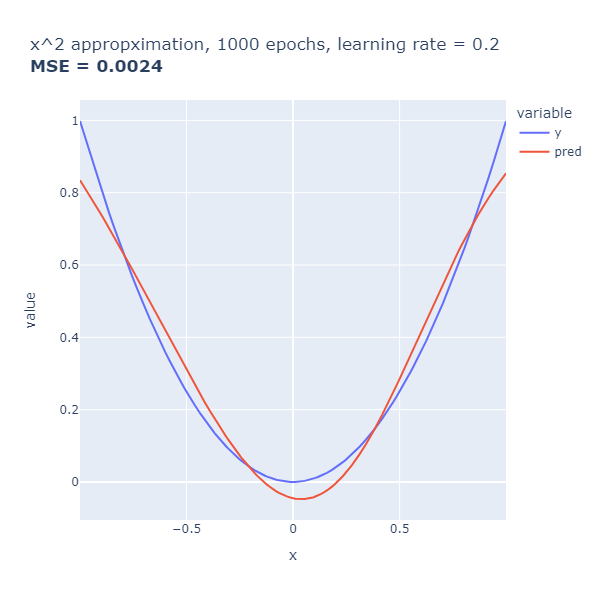

In [11]:
Image("images/square_func_approx.png")

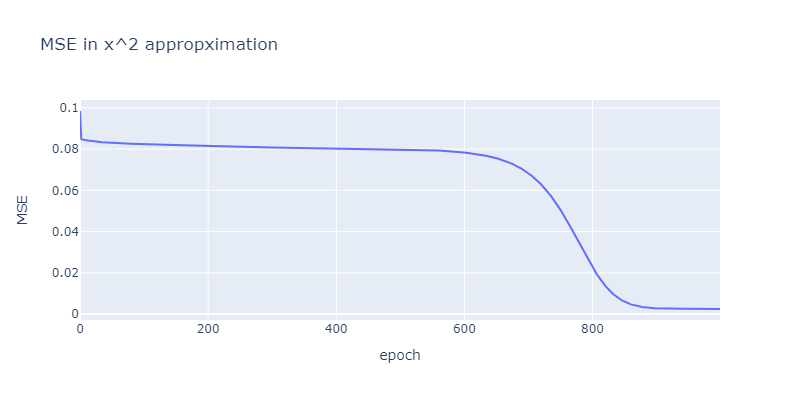

In [13]:
Image("images/square_func_approx_MSE.png")

In [ ]:
data_x, data_y = load_wine(return_X_y=True, as_frame=True)
data_y = pd.get_dummies(data_y)
scaler = StandardScaler()
data_x = pd.DataFrame(scaler.fit_transform(data_x, data_y), columns=data_x.columns)
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
train = x_train.join(y_train)
test = x_test.join(y_test)

In [ ]:
mlp = MLP([15, 15, 3], 13, ['ReLU', 'ReLU', 'softmax'], loss_func='crossEntropy')
mlp.initialize_weights('ones')
mlp.train(train, [0, 1, 2], 1, strategy='SGD', epoch_number=10, mini_batch_size=30)

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:57: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:57: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:117: RuntimeWarning:

invalid value encountered in multiply

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:57: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:57: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:57: RuntimeWarning:

divide by zero encountered in scalar divide

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:57: RuntimeWarning:

invalid value encountered in scalar divide

C:\Users\filip\AppData\Local\Temp\ipykernel_8884\3499593251.py:117: RuntimeWarning:

invalid value encount

In [ ]:
preds = mlp.predict(x_test).to_frame()
preds = preds[0].apply(lambda x: x.index(max(x)))

In [ ]:
# reverse one hot
true = test[[0, 1, 2]].idxmax(axis=1)

In [ ]:
def report(y_test, y_pred):
    clf_report = classification_report(y_test, y_pred, output_dict=True)
    heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, cmap="crest")

def confusions(y_test, y_pred):
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot = heatmap(pd.DataFrame(conf_matrix, index = [0, 1, 2],
                                columns=[0, 1, 2]), annot=True, cmap="crest")
    plot.set(xlabel='Predicted Label', ylabel='True Label')
    plot

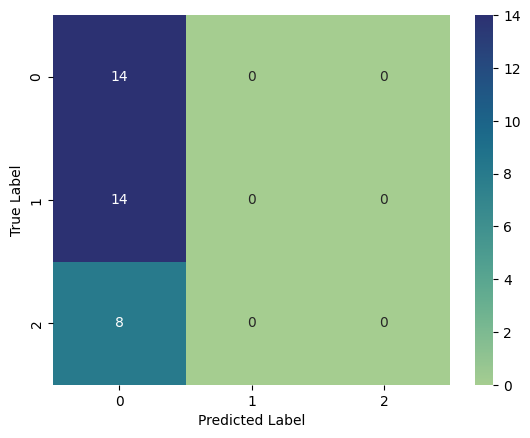

In [ ]:
confusions(true, preds)

C:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



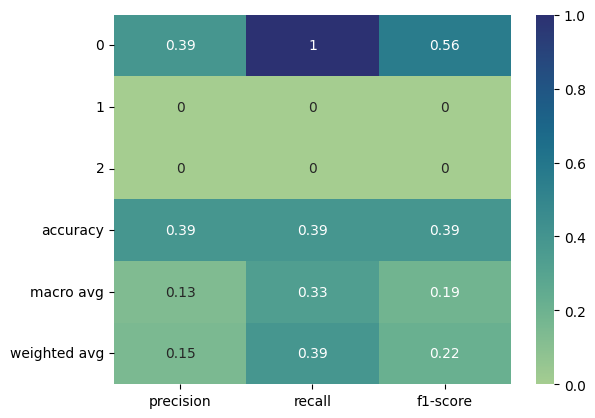

In [ ]:
report(true, preds)